Ce notebook a été développé par Nil-Dany MOSTEFAI dans le cadre de l'UE "Signal processing and deep learning"

In [1]:
import numpy as np
import sklearn as skl
from sklearn.metrics import ConfusionMatrixDisplay
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import find_peaks
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import normalize, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from tqdm import tqdm
from sklearn.svm import SVC


# NOTE
Les parties "Analyse et visualisation des données" et "Apprentissage basique" sont indépendantes.
Vous pouvez exécuter l'une ou l'autre à votre bon vouloir.
Cependant tout code situé en dehors de ces deux parties doit obligatoirement être exécuté.

In [2]:
from IPython.core.display import HTML
HTML("""
<style>
.consignes{
  font-weight: bold;
  color: #3256a8;
  background-color: #edebdf
}
</style>
""")



# TP2: Détection de menaces radar

<div class=consignes> Listez les noms des étudiants (2 au maximum) ayant participé à ce notebook dans la cellule suivante (prénom, nom, affectation).<br/>
- MOSTEFAI Nil-Dany (Sans binôme).£
Au moment du rendu, le notebook doit être nommé nom1_nom2_dlts_tp2.ipynb

2 séances de TP sur ce sujet : le 16 octobre (1h30) et le 23 octobre (3h).<br>
Deadline : 30 otobre 2024, 13h59, par mail à deepetsignal.mva@gmail.com <br>

Pour installer les paquets nécessaires à la réalisation de ce TP vous pouvez utiliser dans le notebook
    
```
!pip install \< nom_du_paquet \>
```
merci de regrouper toutes les installations dans la première cellule du notebook.
Essayez de faire en sorte que votre notebook puisse se lire comme un compte rendu, évitez de laisser du code mort et prennez le temps de commenter vos observations et résultats.
    
## Mission


Vous commandez un avion de reconnaissance en mission top secrète. Malgré votre discretion et toutes les précautions prises vous dérangez et pouvez être sujet de menaces qu'il vous faut détecter pour garantir la sécurité de votre équipage et la succès de votre mission (comme elle est top secrète vous ne pouvez pas en savoir plus).

A votre disposition un réseau d'antennes et un système d'analyse spectrale perfectionnés vous permettent d'extraire et de caractériser des signaux en provenance des radars à altitude 0 qui parsèment votre parcours.

Un signal radar est composé d'impulsions. Le système d'analyse vous permettent de caractériser chaque impulsion reçue par un PDW (Pulse Description Word) qui contient:

- la date de début de détection de l'impulsion (en ms)
- la largeur ou durée de l'impulsion (en ms)
- la puissance de l'impulsion (en dB / référence)
- l'angle theta et l'angle phi décrivant la direction dans laquelle l'impulsion est détectée (en radians)
- la fréquence de l'impulsion (en Ghz)

Votre capteur n'est pas parfait et vous subissez notamment un phénomène de mitage: une certaine proportion des impulsions émises ne sont pas détectées. Cette proportion est d'autant plus grande que la puissance des impulsions est petite.  

Votre vaisseau navigue à 10 km d'altitude, avec une vitesse constante de 1000 km/h vers le nord.

De précédentes missions ont permis de réaliser une base de données de signaux de 10 secondes.
Chaque signal se présente sous la forme d'un fichier .npz qui contient l'ensemble des PDW reçus.

Un signal est donc un fichier dont le nom est de la forme 'pdw_<numéro du signal>.npz'.

Cette base de données est annotée: le destin de chaque mission a permis de déclarer chaque signal comme une 'menace' ou une 'nonmenace'.

Les signaux ont été divisés en deux ensembles indépendants:
    
- train
- test

Les annotations pour chaque ensemble sont disponibles dans le fichier labels_<train ou test>.json qui donne l'association nom de fichier -> menace ou nonmenace.
    
    
Votre mission (si vous l'acceptez) est de choisir et d'entrainer un algorithme d'apprentissage machine à détecter les menaces sur l'ensemble 'train' et à évaluer ses performances sur l'ensemble 'test'.

Fort de votre expérience passée, vous décidez de suivre la méthodologie suivante:

- Visualisation et analyse des données pour trouver les paramètres les plus pertinents à utiliser
- Sélection d'un algorithme naïf "baseline" de référence: vous définissez un premier algorithme simple et caractérisez ses performances qui serviront de point de comparaison pour qualifier l'apport d'algorithmes plus sophistiqués
- Vous utilisez la bibliothèque sklearn et notamment ses implémentations d'algorithmes de classification binaire pour définir et entrainer sur l'ensemble 'train' un ou plusieurs algorithmes en capacité de prédire le label menance ou nonmenace de chaque signal (https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html)
- Vous qualifiez les performances de vos algorithmes en termes d'accuracy (https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html#sklearn.metrics.accuracy_score) ; vous calculez aussi les matrices de confusion (https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html#sklearn.metrics.confusion_matrix)
    
Pour ce TP nous ne cherchons pas à mettre en place des algorithmes d'apprentissage profond. Ces méthodes pourront être investiguées dans un deuxième temps.
    
 Si les résultats vous semblent décevants, souvenez vous des conseils de votre prédecesseur et mentor G. Abitbol: "toujours donner un coup de pouce à un algo de machine learning  en lui présentant les bonnes données"

Vous pouvez ouvrir un fichier de la façon suivante:

</div>    

<div class=consignes> et les fichiers d'annotations:</div>

<div class=consignes> On compte sur vous, bonne chance ! </div>

In [3]:

def load_dataset():
  folder_root = "radars"
  columns = ['date', 'largeur', 'frequence', 'puissance', 'theta', 'phi', 'label']
  dataset = {"train" : {}, "test" : {}}
  for type_data in dataset.keys():
    for column in columns:
      dataset[type_data][column] = {}
    folder = os.path.join(folder_root, type_data)
    with open(os.path.join(folder_root, type_data + "_labels.json")) as f:
      labels = json.load(f)

    for filename in os.listdir(folder):
      print(os.path.join(folder, filename))
      pdws = np.load(os.path.join(folder, filename))
      key = filename.split(".")[0]
      label = labels[key]
      pdws = dict(pdws)
      pdws["label"] = label
      for column in columns:
        dataset[type_data][column][key] = pdws[column]
  return dataset

In [5]:
%%capture
dataset = load_dataset()

In [6]:
df_train = pd.DataFrame(dataset["train"])
df_test = pd.DataFrame(dataset["test"])

In [7]:
df_train

,date,largeur,frequence,puissance,theta,phi,label
pdw-308,"[5.1850000000000005, 28.526, 36.307, 68.728, 8...","[0.181, 0.181, 0.179, 0.179, 0.18, 0.179, 0.18...","[1.7357850329585311, 1.7220397643144598, 1.738...","[-134.12383561273148, -169.49321982318526, -14...","[0.02354464109278738, -0.23491080329346675, -0...","[1.4563975967766274, 1.87657343155606, 1.55367...",nonmenace
pdw-945,"[2.317, 4.287, 4.5680000000000005, 5.412, 7.66...","[0.026000000000000002, 0.024, 0.02600000000000...","[2.1017497373440857, 2.117427999751814, 2.1021...","[-115.42845108399987, -117.04538883214471, -11...","[0.4064203359266304, 0.4416881034111914, 0.468...","[1.6416372363528073, 1.6803129740503508, 1.589...",menace
pdw-514,"[1.709, 8.056000000000001, 14.399000000000001,...","[0.059000000000000004, 0.061, 0.05900000000000...","[1.9984824033126636, 1.9776310519203146, 1.969...","[-143.6193608523437, -144.8050703490085, -143....","[-1.5987979844283133, -2.124937669604376, -1.8...","[1.6714245202133644, 1.2477073578398286, 1.706...",nonmenace
pdw-434,"[1.48, 2.682, 3.884, 5.891, 8.295, 9.098, 13.1...","[0.02, 0.019, 0.021, 0.02, 0.021, 0.019, 0.021...","[3.2627870330466697, 3.2624554496439964, 3.279...","[-127.83178953530094, -127.91604160417722, -12...","[2.4978509558036666, 2.5332764361734523, 2.410...","[1.4117626697183425, 1.298939727183924, 1.5206...",nonmenace
pdw-1386,"[2.444, 4.0200000000000005, 38.676, 41.0380000...","[0.068, 0.066, 0.068, 0.067, 0.066, 0.066, 0.0...","[1.7563573604758458, 1.7576597822987021, 1.751...","[-133.38188329723144, -133.4070018638482, -132...","[3.2632986486340805, 2.960655798302536, -2.931...","[1.3869319366592547, 1.3555952999219016, 1.784...",nonmenace
...,...,...,...,...,...,...,...
pdw-278,"[3.092, 43.145, 57.709, 85.017, 86.837, 90.48,...","[0.422, 0.422, 0.424, 0.422, 0.424, 0.424, 0.4...","[1.435633195411925, 1.43676095092851, 1.433442...","[-97.91948908954475, -97.65292154410923, -98.8...","[-2.2325226377636236, -1.6968039323606279, -1....","[1.4558368689373755, 1.6330379040569096, 1.495...",menace
pdw-1205,"[7.054, 8.47, 31.124000000000002, 33.957, 46.6...","[0.182, 0.18, 0.182, 0.182, 0.18, 0.181, 0.181...","[2.2582606861232573, 2.261182033791596, 2.1609...","[-82.40333483389685, -82.44569165017838, -85.1...","[-2.3563397974547655, -2.673419226650647, -2.1...","[1.5645595586320673, 1.5564696760623418, 1.823...",menace
pdw-353,"[7.077, 18.85, 50.241, 56.126, 60.050000000000...","[0.312, 0.311, 0.312, 0.312, 0.313, 0.311, 0.3...","[1.8059124327877798, 2.172290651900116, 1.9616...","[-163.24196693618333, -137.3778303327131, -127...","[-0.7617409301730718, -0.6118381821994797, -0....","[1.4635811234198066, 1.7706093744434788, 1.513...",menace
pdw-1791,"[4.5600000000000005, 6.454, 7.085, 13.397, 26....","[0.073, 0.075, 0.073, 0.075, 0.074, 0.075, 0.0...","[2.5547719438499756, 2.5690826607474904, 2.560...","[-135.76185735507497, -136.43146898833496, -13...","[-0.9757185526359233, -1.127502023877341, -1.1...","[1.2340012135709055, 1.8574973138484772, 1.643...",nonmenace


# Analyse et visualisation des données

À vu d'oeil, les impulsions de plus grandes largeur semblent avoir une probabilité plus grande d'être menaçant.

In [8]:
def construct_means_stds(dataset):
  res = pd.DataFrame()
  for attribute in dataset.columns:
    if attribute == "label":
      continue
    means = dataset[attribute].apply(np.mean)
    stds = dataset[attribute].apply(np.std)
    res = pd.concat((res, pd.DataFrame({f"{attribute}_mean": means , f"{attribute}_std" : stds})), axis = 1)
  labels = dataset["label"]
  res = pd.concat((res, labels), axis = 1)
  res_menace = res.loc[res["label"] == "menace"]
  res_menace["label"] = 1
  res_non_menace = res.loc[res["label"] == "nonmenace"]
  res_non_menace["label"] = 0

  return pd.concat((res_menace, res_non_menace), axis = 0)
df_mean_std= construct_means_stds(df_train)

/tmp/ipykernel_244135/1938835240.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res_menace["label"] = 1
/tmp/ipykernel_244135/1938835240.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res_non_menace["label"] = 0


In [9]:
df_mean_std

,date_mean,date_std,largeur_mean,largeur_std,frequence_mean,frequence_std,puissance_mean,puissance_std,theta_mean,theta_std,phi_mean,phi_std,label
pdw-945,4985.387748,2893.691723,0.025014,0.000810,2.099406,0.008319,-159.185832,13.410194,-1.484834,0.277041,1.572751,0.157369,1
pdw-544,5028.143543,2845.378093,0.114020,0.000808,1.963626,0.007749,-150.437304,12.253492,-1.704490,0.254952,1.571593,0.158207,1
pdw-1698,4998.362490,2921.981295,0.158041,0.000802,1.901611,0.007484,-156.407431,12.539799,-1.452768,0.219798,1.574500,0.153647,1
pdw-1651,5066.852748,2865.743327,0.041991,0.000815,0.898550,0.003630,-156.143029,13.243198,-1.435661,0.253588,1.573155,0.155377,1
pdw-1562,4868.020932,2824.843351,0.140989,0.000822,1.814800,0.107426,-153.678274,12.116289,-1.396618,0.448962,1.565067,0.157813,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
pdw-242,4905.810216,2815.867771,0.299986,0.000814,2.520079,0.010350,-147.005930,13.261984,-1.548629,0.766591,1.557469,0.151902,0
pdw-1060,5066.395296,2889.355232,0.016969,0.000824,1.067440,0.004335,-182.045547,10.487133,-1.616979,0.176532,1.571804,0.158398,0
pdw-980,4989.649820,2865.316221,0.118007,0.000812,1.165794,0.004774,-161.559264,11.843652,-1.494949,0.190541,1.575426,0.157675,0
pdw-1791,4914.932022,2911.938523,0.074009,0.000828,2.558644,0.010218,-166.790289,13.401066,-1.544856,0.162620,1.572064,0.156467,0


/tmp/ipykernel_244135/2646877474.py:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


<Figure size 640x480 with 0 Axes>

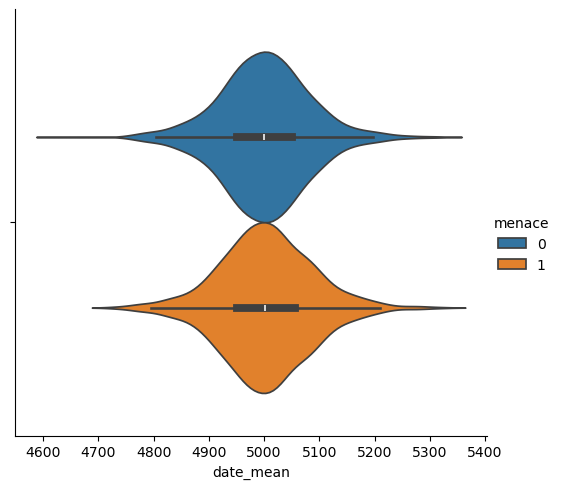

<Figure size 640x480 with 0 Axes>

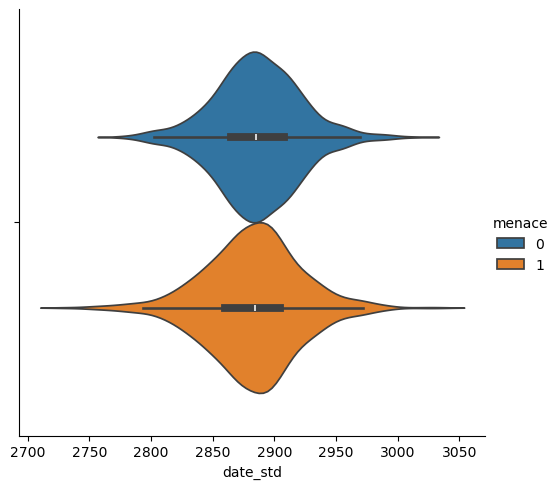

<Figure size 640x480 with 0 Axes>

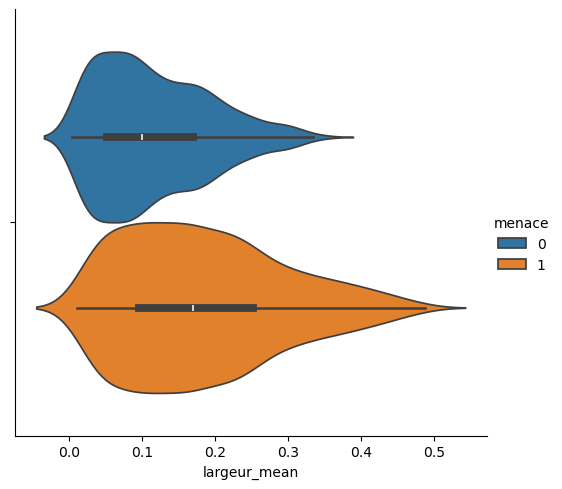

<Figure size 640x480 with 0 Axes>

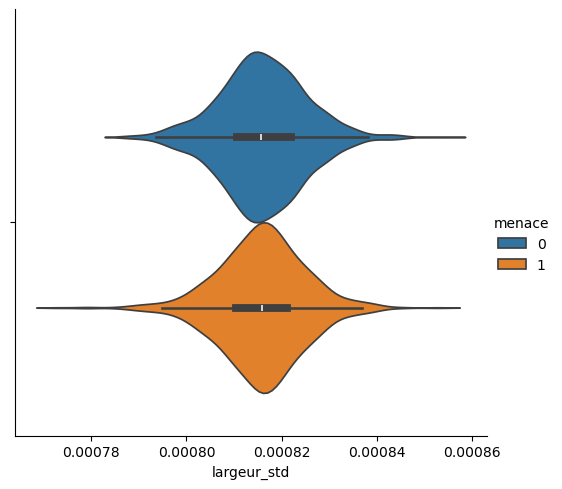

<Figure size 640x480 with 0 Axes>

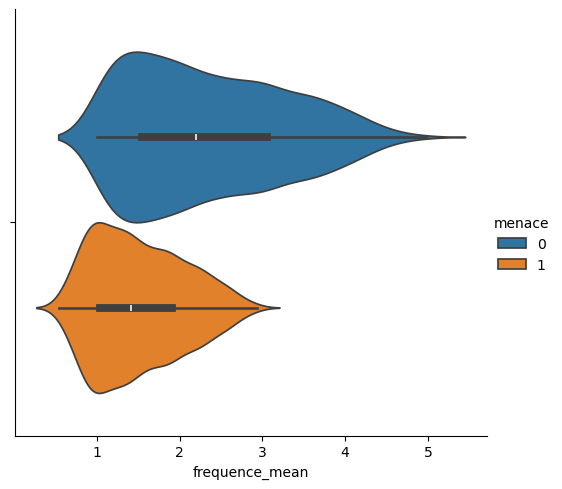

<Figure size 640x480 with 0 Axes>

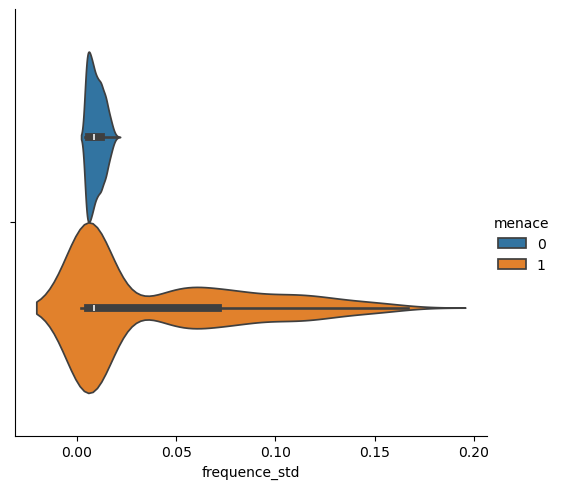

<Figure size 640x480 with 0 Axes>

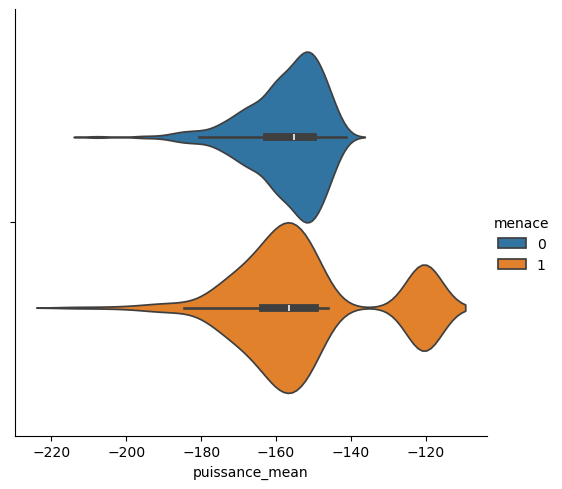

<Figure size 640x480 with 0 Axes>

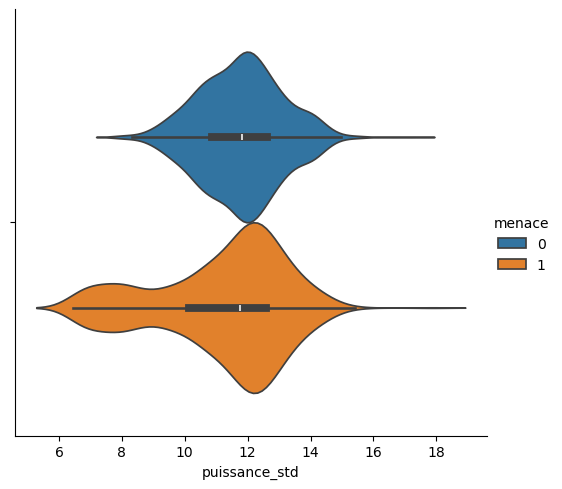

<Figure size 640x480 with 0 Axes>

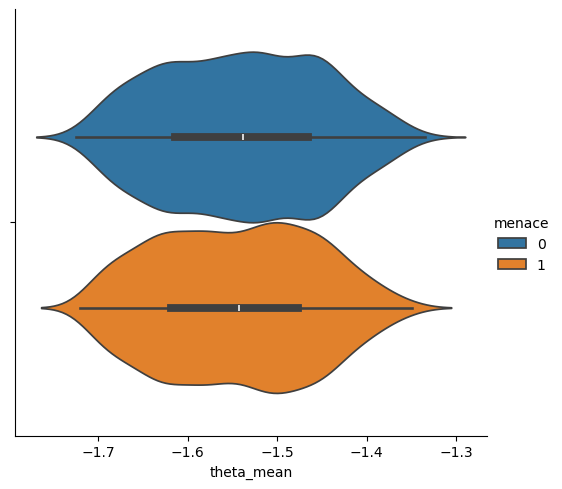

<Figure size 640x480 with 0 Axes>

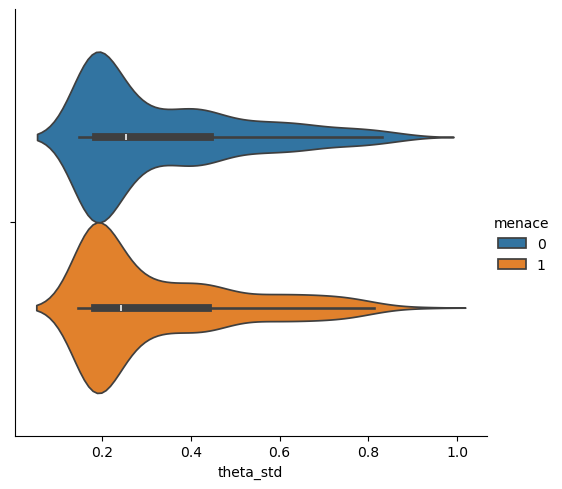

<Figure size 640x480 with 0 Axes>

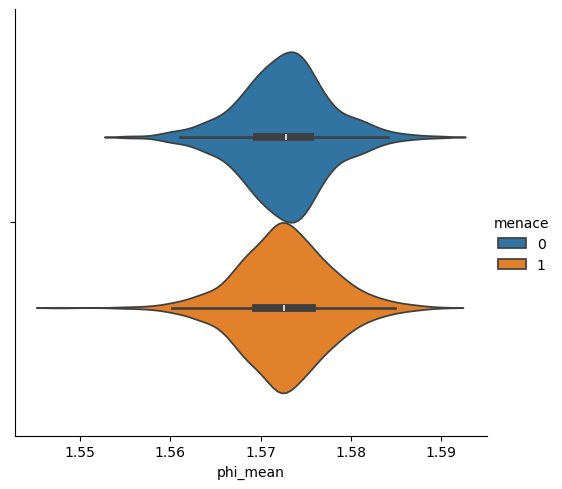

<Figure size 640x480 with 0 Axes>

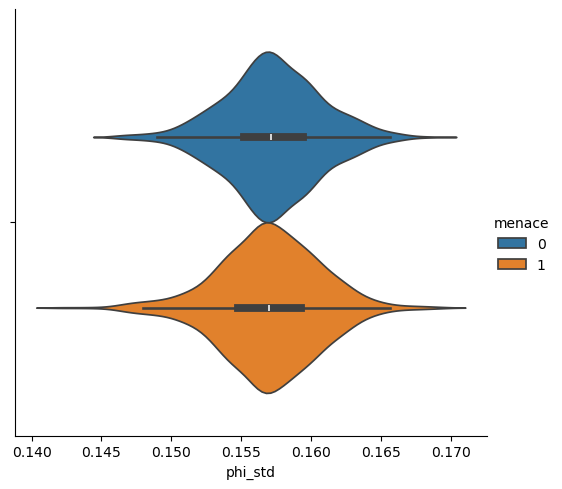

In [10]:

def plot_dif(df_mean_std):
  for col in df_mean_std.columns:
    if col.split("_")[-1] == "std" or col == "label":
      continue
    mean_att = col
    splits = col.split("_")
    if splits[-1] == "mean":   
        std_att = col.split("_")[0] + "_std"
        df = pd.DataFrame({mean_att : df_mean_std[mean_att], std_att : df_mean_std[std_att], "menace" : df_mean_std["label"]})
    else:
        df = pd.DataFrame({mean_att : df_mean_std[mean_att], "menace" : df_mean_std["label"]})
    
    plt.figure()

    sns.catplot(data = df , x = mean_att, kind = "violin", hue = "menace")
    if splits[-1] == "mean":
        plt.figure()
        sns.catplot(data = df , x = std_att, kind = "violin", hue = "menace")

plot_dif(df_mean_std)

## Observations.

Les figures au-dessus permettent de visualiser des distributions de listes de moyennes et de déviations.
Par exemple, la première figure indique la distribution des moyennes de dates des signaux.
La valeur centrale indique "la moyenne des moyennes" (car on a auparavant fait une moyenne sur la liste des dates de chaque exemple), et on peut aussi observer la variation des valeurs autour de cette moyenne.
On dessine cette figure pour chaque type de label (0 pour non menançant et 1 pour menaçant), et pour chaque type d'attribut.

On remarque que les exemples sont assez bien discriminés par la moyenne des fréquences : une moyenne de fréquence plus basse implique une probabilité plus grande que le signal soit menaçant.
Par ailleurs, les signaux non menaçants présentent des fréquences très peu variables contrairement aux signaux menaçants.

La puissance moyenne permet également de discriminer une grande partie des signaux menançants : Un signal avec une puissance moyenne supérieure à -140 db est forcément un signal menaçant dans notre dataset. Les signaux menaçants ont également une standard déviation pour leur puissance beaucoup plus faible.

Dans une moindre mesure, la moyenne des largeurs de signaux menaçants est plus étalée vers la droite que celle des signaux non menaçants.




Pour l'effet de mitage, on peut s'attendre à ce qu'on reçoive moins d'impulsions provenant d'un signal menaçant.

In [11]:
df_train["nb_impulsions"] = df_train["date"].apply(np.size)

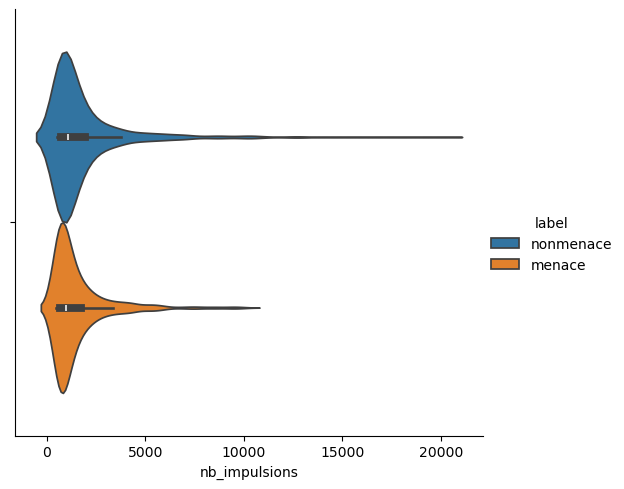

In [12]:
sns.catplot(data = df_train, kind = "violin", x = "nb_impulsions", hue = df_train["label"])

En moyenne, la différence entre le nombre d'impulsions de signaux menaçants et le nombre d'impulsions de signaux non menaçants n'est pas significative. Cependant, on constate que les signaux non menaçants présentent une variance plus élevée. On peut s'attendre à ce que certains "outliers", qui possèdent beaucoup trop d'impulsions, ne soient pas menaçants.

<Figure size 640x480 with 0 Axes>

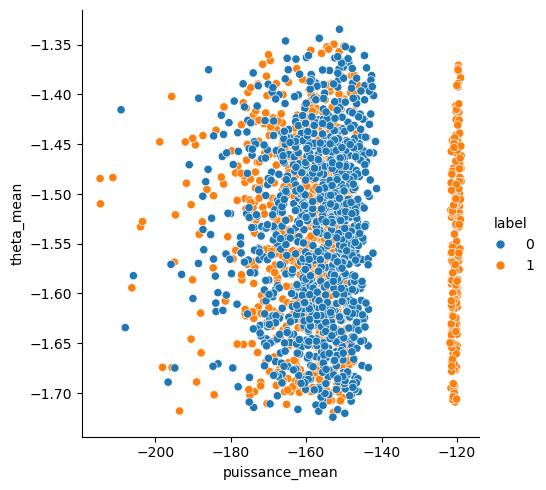

<Figure size 640x480 with 0 Axes>

In [13]:

df_mean_std["nb_impulsions"] = df_train["nb_impulsions"]
sns.relplot(data = df_mean_std , x = "puissance_mean", y ="theta_mean", hue = "label" )
plt.figure()



On peut discriminer une grande partie des signaux menaçants grâce à la moyenne de leur puissance.
La séparation claire entre les signaux de puissance moyenne -120 dB/reference et le reste des signaux laisse penser qu'un modèle de type "arbre de décision" serait performant pour nos données. 

## Visualisation d'une donnée

S'intéresser à la structure de données individuelles peut permettre de trouver des caractéristiques "intéressantes" à fournir à notre modèle.

Pour un exemple de type :  nonmenace


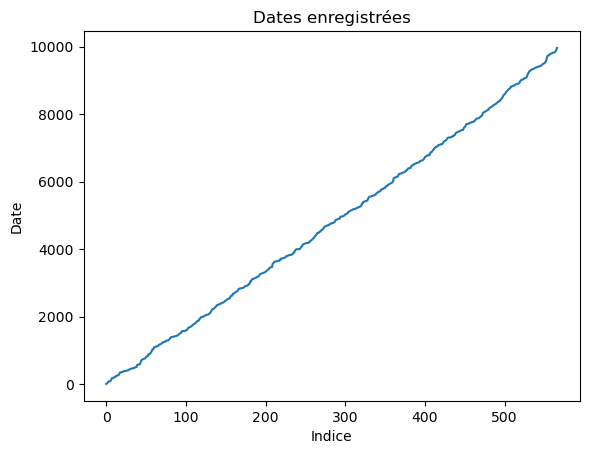

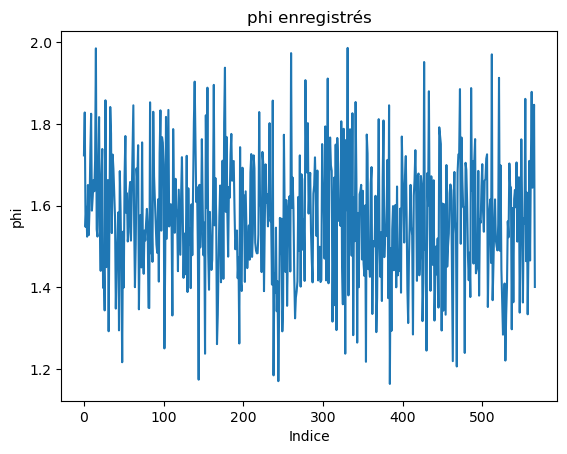

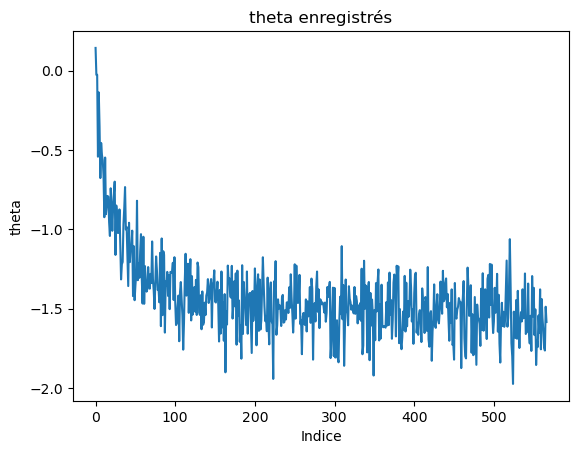

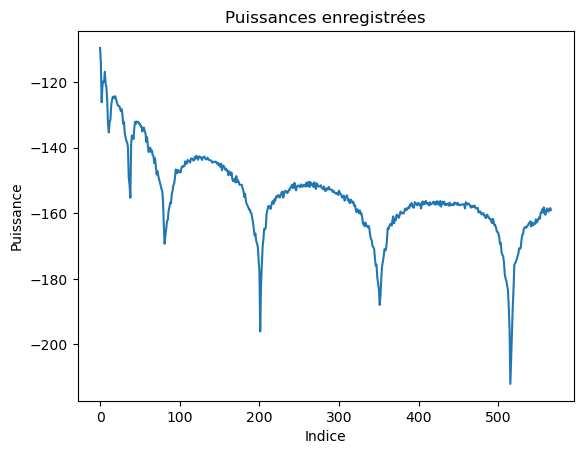

In [14]:
np.random.seed(42)
index = np.random.randint(0, len(df_train), 1)[0]
x = df_train.iloc[index]
print("Pour un exemple de type : ", x["label"])
plt.figure()
plt.xlabel("Indice")
plt.ylabel("Date")
plt.title("Dates enregistrées")
plt.plot(np.arange(0, len(x["date"])), x["date"])
plt.figure()
plt.xlabel("Indice")
plt.ylabel("phi")
plt.title("phi enregistrés")
plt.plot(np.arange(0, len(x["phi"])), x["phi"])
plt.figure()
plt.xlabel("Indice")
plt.ylabel("theta")
plt.title("theta enregistrés")
plt.plot(np.arange(0, len(x["theta"])), x["theta"])
plt.figure()
plt.xlabel("Indice")
plt.ylabel("Puissance")
plt.title("Puissances enregistrées")
plt.plot(np.arange(0, len(x["puissance"])), x["puissance"])


Pour un exemple de type :  menace


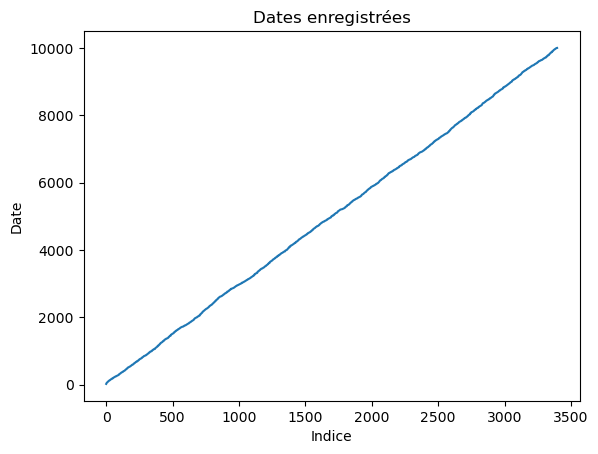

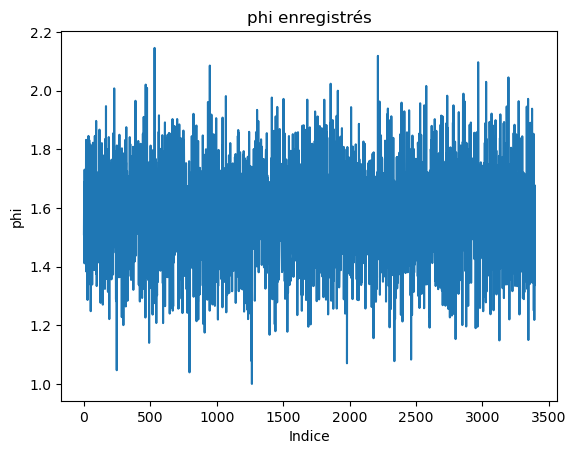

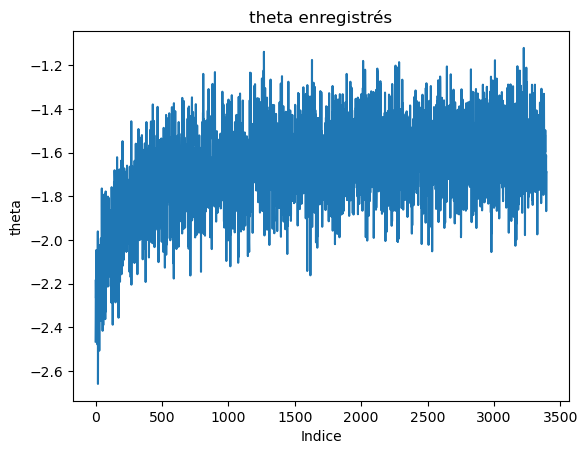

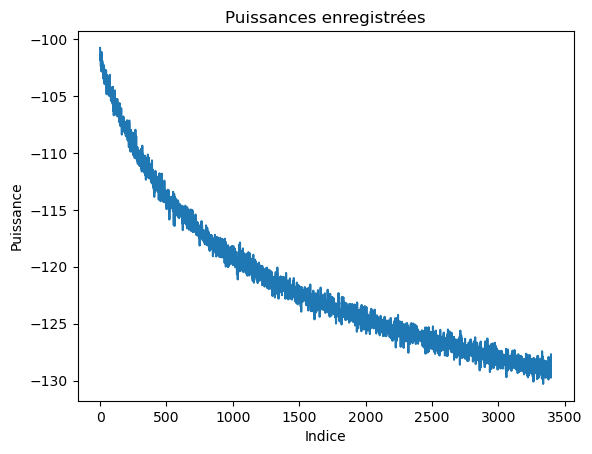

In [15]:
np.random.seed(43)
index = np.random.randint(0, len(df_train), 1)[0]
x = df_train.iloc[index]
print("Pour un exemple de type : ", x["label"])
plt.figure()
plt.xlabel("Indice")
plt.ylabel("Date")
plt.title("Dates enregistrées")
plt.plot(np.arange(0, len(x["date"])), x["date"])
plt.figure()
plt.xlabel("Indice")
plt.ylabel("phi")
plt.title("phi enregistrés")
plt.plot(np.arange(0, len(x["phi"])), x["phi"])
plt.figure()
plt.xlabel("Indice")
plt.ylabel("theta")
plt.title("theta enregistrés")
plt.plot(np.arange(0, len(x["theta"])), x["theta"])
plt.figure()
plt.xlabel("Indice")
plt.ylabel("Puissance")
plt.title("Puissances enregistrées")
plt.plot(np.arange(0, len(x["puissance"])), x["puissance"])

Pour un exemple de type :  menace


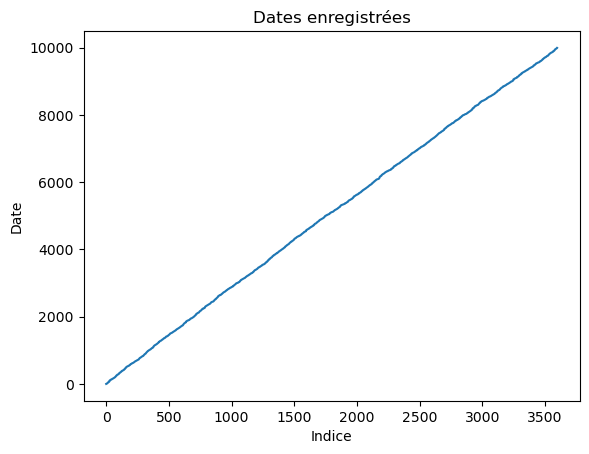

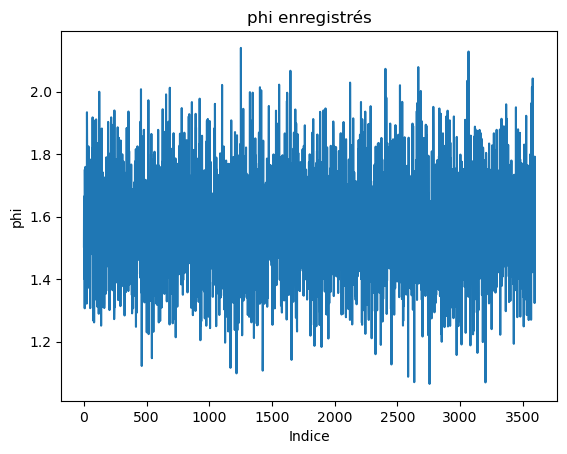

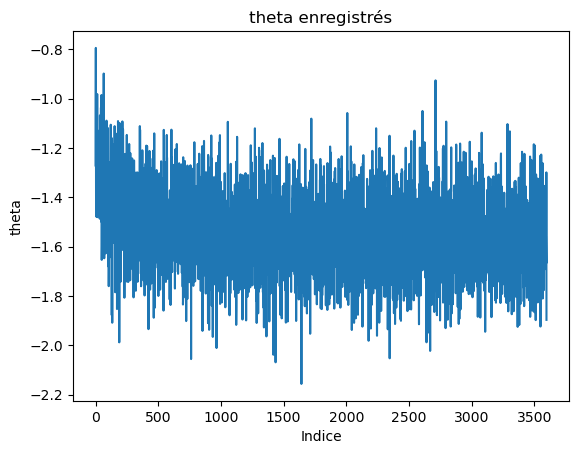

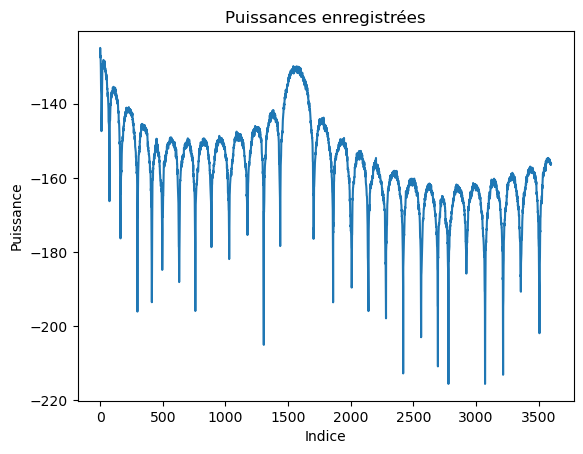

In [16]:
np.random.seed(40)
index = np.random.randint(0, len(df_train), 1)[0]
x = df_train.iloc[index]
print("Pour un exemple de type : ", x["label"])
plt.figure()
plt.xlabel("Indice")
plt.ylabel("Date")
plt.title("Dates enregistrées")
plt.plot(np.arange(0, len(x["date"])), x["date"])
plt.figure()
plt.xlabel("Indice")
plt.ylabel("phi")
plt.title("phi enregistrés")
plt.plot(np.arange(0, len(x["phi"])), x["phi"])
plt.figure()
plt.xlabel("Indice")
plt.ylabel("theta")
plt.title("theta enregistrés")
plt.plot(np.arange(0, len(x["theta"])), x["theta"])
plt.figure()
plt.xlabel("Indice")
plt.ylabel("Puissance")
plt.title("Puissances enregistrées")
plt.plot(np.arange(0, len(x["puissance"])), x["puissance"])


* Les dates sont une fonction linéaire et ne serviront pas dans le modèle.
* Le paramètre phi pour le signal menaçant semble avoir une fréquence bien plus élevée.
* Le paramètre theta est croissant pour le signal menaçant tandis qu'il est décroissant pour le signal non dangereux.
* La puissance du signal non menaçant présente quelques creux tandis que celle du signal menaçant présente soit énormément de creux, soit aucun creux avec une faible décroissance au cours du temps.

L'objectif est donc de capturer ces caractéristiques.
1. Pour phi et theta, ce sont des features beaucoup trop variables selon les exemples, on les ignorera.
2. Pour la puissance, on peut calculer le nombre de creux moyen et la différence entre la puissance à la fin et la puissance au début.

In [17]:
puissances = df_train["puissance"].to_numpy()
puissances_min = [ np.min(puissances[i]) for i in range(len(puissances))]
puissances_max = [ np.max(puissances[i]) for i in range(len(puissances))]
dif_puissances = np.array(puissances_max) - np.array(puissances_min)
df_train["dif_puissance"] = dif_puissances
min_height_peak = 120
number_peaks = np.array([ len(find_peaks(- puissances[i] , height = min_height_peak)[0]) for i in range(len(puissances))])
df_train["number_peaks"] = number_peaks

<Figure size 640x480 with 0 Axes>

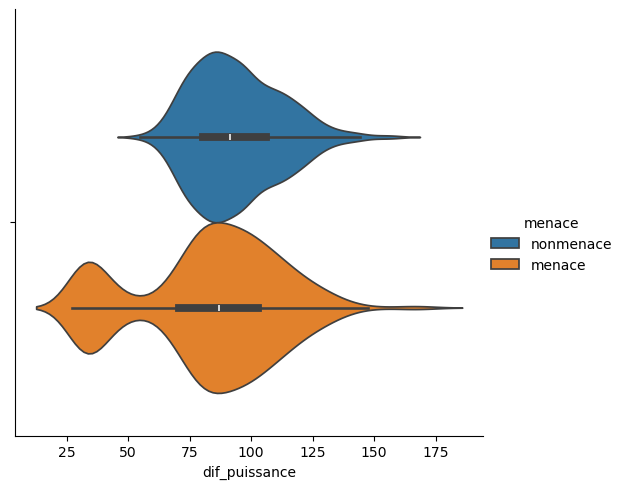

<Figure size 640x480 with 0 Axes>

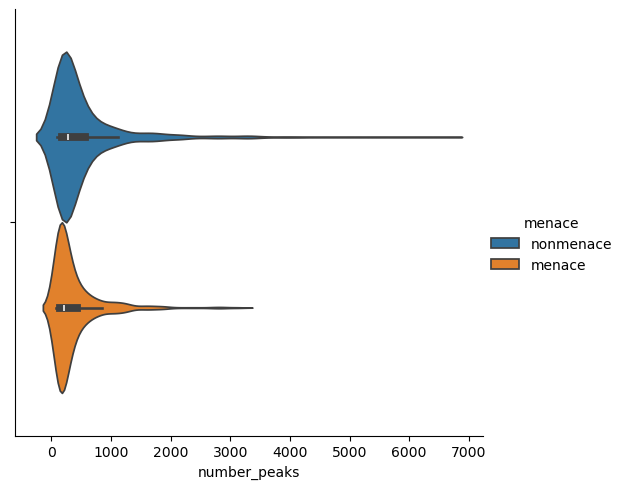

<Figure size 640x480 with 0 Axes>

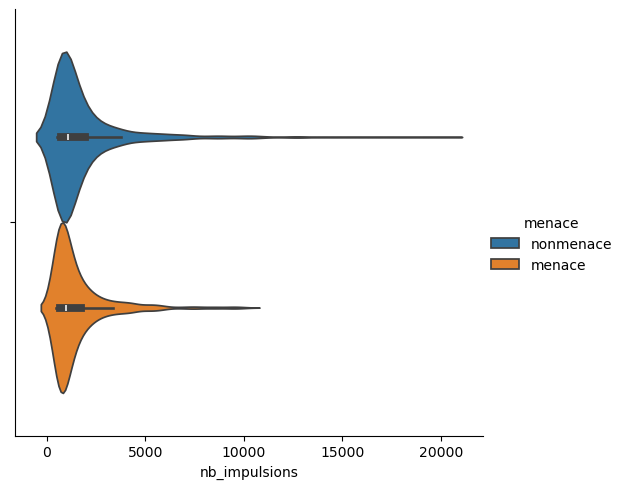

In [18]:
df_to_plot = df_train.copy()
df_to_plot = df_to_plot[["dif_puissance", "number_peaks", "nb_impulsions", "label"]]

plot_dif(df_to_plot)

La difference de puissance permet d'isoler un groupe de signaux menaçants, mais semble être redondant avec la moyenne de puissance.
Le nombre de pics n'est pas très utile, mais peut permettre de détecter un signal menaçant dans certains cas (Les signaux menaçants tendent à avoir moins de pics).

# Apprentissage basique

## Random Forest

Les attributs conservés sont la fréquence moyenne/déviation, la largeur moyenne/deviation , la difference puissance, la puissance moyenne/deviation, le nombre d'impulsions et le nombre de pics.

In [19]:
%%capture
dataset = load_dataset()

In [20]:
df_train = pd.DataFrame(dataset["train"])
df_test = pd.DataFrame(dataset["test"])

In [21]:

def clean(df):
    df = df[["frequence", "largeur", "puissance", "label"]]
    df["frequence_mean"] = df["frequence"].apply(np.mean)
    df["frequence_std"] = df["frequence"].apply(np.std)
    df["largeur_mean"] = df["largeur"].apply(np.mean)
    df["largeur_std"] = df["largeur"].apply(np.std)
    df["puissance_mean"] = df["puissance"].apply(np.mean)
    df["puissance_std"] = df["puissance"].apply(np.std)
    df["nb_impulsions"] = df["frequence"].apply(np.size)
    puissances = df["puissance"].to_numpy()
    puissances_min = [ np.min(puissances[i]) for i in range(len(puissances))]
    puissances_max = [ np.max(puissances[i]) for i in range(len(puissances))]
    df["dif_puissance"] = np.array(puissances_max) - np.array(puissances_min)

    min_height_peak = 120
    number_peaks = np.array([ len(find_peaks(- puissances[i] , height = min_height_peak)[0]) for i in range(len(puissances))])
    df["number_peaks"] = number_peaks
    df = df.drop(columns = ["frequence", "largeur", "puissance"])
    return df

In [22]:
df_train= df_train[["frequence", "largeur", "puissance", "label"]]
df_test = df_test[["frequence", "largeur", "puissance", "label"]]

In [23]:
df_train = clean(df_train.copy())
df_test = clean(df_test.copy())

In [24]:
y_train = df_train["label"].to_numpy()
y_test = df_test["label"].to_numpy()
y_train = np.where(y_train == "menace", [1], [0])
y_test = np.where(y_test == "menace", [1], [0])


In [11]:
X_train = df_train.drop(columns = ["label"]).to_numpy()
X_test = df_test.drop(columns = ["label"]).to_numpy()

Après avoir nettoyé les données, on peut commencer la classification, on va d'abord faire un test préliminaire pour savoir à quel point le modèle marche.

In [314]:
clf = RandomForestClassifier()
clf.fit(X_train, y_train)

RandomForestClassifier()

In [318]:
print("Score pour le random forest : ", clf.score(X_test, y_test))

Score pour le random forest :  0.84875


Il s'agit d'un très bon score qu'on peut optimiser en utilisant les bons hyperparamètres.
Pour trouver une bonne combinaison d'hyperparamètres, on va utiliser une GridSearch associée à une crossvalidation pour avoir des résultats robustes.
Avant de faire ça, on veut savoir si le paramètre "dif_puissance" est redondant. Pour ce faire, on va relancer un entraînement du même modèle avec un jeu de données où l'on a retiré la difference de puissance.

In [390]:
X_train = df_train.drop(columns = ["label", "dif_puissance"]).to_numpy()
X_test = df_test.drop(columns = ["label", "dif_puissance"]).to_numpy()

In [329]:
clf = RandomForestClassifier()
clf.fit(X_train, y_train)
print("Score pour le random forest : ", clf.score(X_test, y_test))

Score pour le random forest :  0.85125


Le résultat est encore meilleur, il peut sûrement s'agir d'une réalisation chanceuse, mais on va tout de même retirer le paramètre "dif_puissance".

### Recherche des hyperparamètres.

In [363]:

clf = RandomForestClassifier()
grid = {"n_estimators": np.logspace(0, 3, 100).astype("int")}
gs = GridSearchCV(estimator = clf , param_grid = grid, cv = 3, verbose=2)
# Fit the random search model
gs.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] END .....................................n_estimators=1; total time=   0.0s
[CV] END .....................................n_estimators=1; total time=   0.0s
[CV] END .....................................n_estimators=1; total time=   0.0s
[CV] END .....................................n_estimators=1; total time=   0.0s
[CV] END .....................................n_estimators=1; total time=   0.0s
[CV] END .....................................n_estimators=1; total time=   0.0s
[CV] END .....................................n_estimators=1; total time=   0.0s
[CV] END .....................................n_estimators=1; total time=   0.0s
[CV] END .....................................n_estimators=1; total time=   0.0s
[CV] END .....................................n_estimators=1; total time=   0.0s
[CV] END .....................................n_estimators=1; total time=   0.0s
[CV] END .....................................

GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid={'n_estimators': array([   1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    2,
          2,    2,    2,    2,    2,    3,    3,    3,    3,    4,    4,
          4,    4,    5,    5,    6,    6,    7,    7,    8,    8,    9,
         10,   10,   11,   12,   13,   14,   15,   16,   17,   18,   20,
         21,   23,   24,   26,   28,   30,   32,   35,   37,   40,   43,
         46,   49,   53,   57,   61,   65,   70,   75,   81,   86,   93,
        100,  107,  114,  123,  132,  141,  151,  162,  174,  187,  200,
        215,  231,  247,  265,  284,  305,  327,  351,  376,  403,  432,
        464,  497,  533,  572,  613,  657,  705,  756,  811,  869,  932,
       1000])},
             verbose=2)

In [370]:
print("Les meilleurs paramètres : ", gs.best_params_, ". Pour un score de :", gs.best_score_)
clf = rf.best_estimator_

Les meilleurs paramètres :  {'n_estimators': 432} . Pour un score de : 0.8849959404682043


In [371]:
print("Score pour le jeu de test : ", clf.score(X_test, y_test))

Score pour le jeu de test :  0.84875


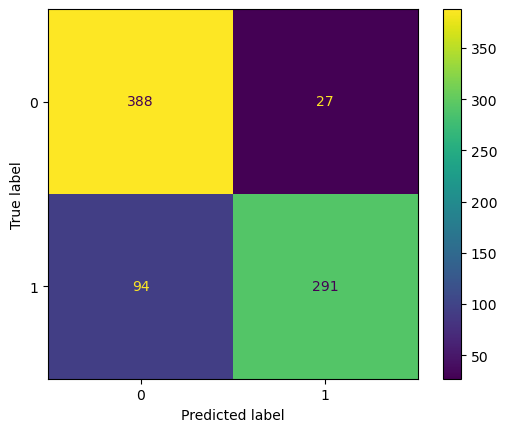

In [399]:
ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test)

Les faux négatifs sont beaucoup plus fréquents que les faux positifs, ce qui est plutôt inquiétant dans le cadre de notre application ("Mieux vaut prévenir que guérir", c'est à dire, mieux vaut considérer un signal pacifique comme dangereux, plutôt que de considérer un signal dangereux comme sans danger).

In [394]:
# Test pour un exemple
i = np.random.randint(0, len(X_test), 1)[0]
x = X_test[i]
print("Index ", i, ": ")
print("Real label is :" , y_test[i])
print("Predicted label is : ", clf.predict([x]))

Index  483 : 
Real label is : 0
Predicted label is :  [0]


## Knn

In [12]:
scaler = StandardScaler()
X_train_normalized = scaler.fit_transform(X_train)
X_test_normalized = scaler.fit_transform(X_test)
#X_train_normalized = normalize(X_train, axis = 0)
#X_test_normalized = normalize(X_test, axis = 0)

100%|███████████████████████████████████████████████████████████████████████████████████| 50/50 [00:05<00:00,  8.77it/s]


<ErrorbarContainer object of 3 artists>

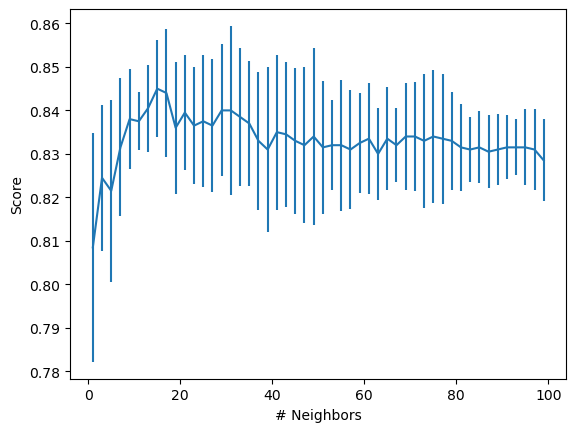

In [432]:

knn.fit(X_train_normalized, y_train)
knn.score(X_test_normalized, y_test)
scores = []
scores_std = []
neighbors = range(1, 100, 2) 
for i in tqdm(neighbors) :
    knn = KNeighborsClassifier(i)
    scores_crossval = cross_val_score(knn, X_train_normalized, y_train, cv = 5)
    mean_score = np.mean(scores_crossval)
    std = np.std(scores_crossval)
    scores.append(mean_score)
    scores_std.append(std)
plt.xlabel("# Neighbors")
plt.ylabel("Score")
plt.errorbar(neighbors, scores, scores_std)

A première vu le knn semble être un bon choix.

In [436]:
index = np.argmax(scores)
n_neighbors = list(neighbors)[index]
print("Pour ", n_neighbors, " voisins: score de ", scores[index], " et std de ", scores_std[index])

Pour  15  voisins: score de  0.845  et std de  0.011180339887498938


In [438]:
knn = KNeighborsClassifier(n_neighbors)
knn.fit(X_train_normalized, y_train)
score = knn.score(X_test_normalized, y_test)
print("Score de ", score)

Score de  0.8075


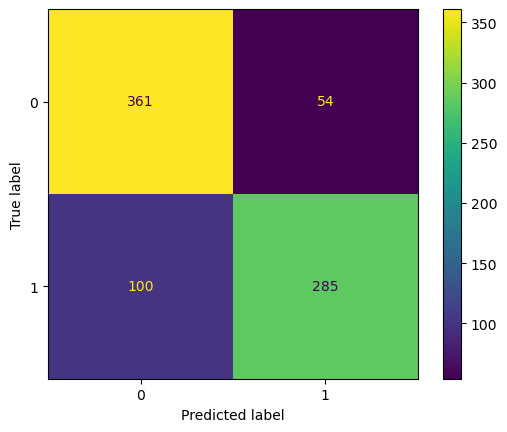

In [439]:
ConfusionMatrixDisplay.from_estimator(knn, X_test_normalized, y_test)

Le knn s'en sort surprenement bien, mais reste beaucoup moins performant que le RandomForest.

## SVM

Explorer ces algorithmes de classification n'a pas pour but de trouver un classifieur absolument meilleur que le random forest, mais d'en trouver un qui fait le bon compromis entre faux-négatifs et accuracy générale.

In [21]:

svm = SVC()
grid = {"C": np.logspace(0, 3, 100), "kernel" : ["linear", "poly", "rbf", "sigmoid"]}
gs = GridSearchCV(estimator = svm , param_grid = grid, cv = 5, verbose=2)
# Fit the random search model
gs.fit(X_train_normalized, y_train)

Fitting 5 folds for each of 400 candidates, totalling 2000 fits
[CV] END ...............................C=1.0, kernel=linear; total time=   0.0s
[CV] END ...............................C=1.0, kernel=linear; total time=   0.0s
[CV] END ...............................C=1.0, kernel=linear; total time=   0.0s
[CV] END ...............................C=1.0, kernel=linear; total time=   0.0s
[CV] END ...............................C=1.0, kernel=linear; total time=   0.0s
[CV] END .................................C=1.0, kernel=poly; total time=   0.0s
[CV] END .................................C=1.0, kernel=poly; total time=   0.0s
[CV] END .................................C=1.0, kernel=poly; total time=   0.0s
[CV] END .................................C=1.0, kernel=poly; total time=   0.0s
[CV] END .................................C=1.0, kernel=poly; total time=   0.0s
[CV] END ..................................C=1.0, kernel=rbf; total time=   0.0s
[CV] END ..................................C=

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': array([   1.        ,    1.07226722,    1.149757  ,    1.23284674,
          1.32194115,    1.41747416,    1.51991108,    1.62975083,
          1.7475284 ,    1.87381742,    2.009233  ,    2.15443469,
          2.3101297 ,    2.47707636,    2.65608778,    2.84803587,
          3.05385551,    3.27454916,    3.51119173,    3.76493581,
          4.03701726,    4.32876128,    4.64158883,    4.97702356,
          5.33669923,    5.72236766,    6.13590727,    6.57933225...
        200.92330026,  215.443469  ,  231.01297001,  247.7076356 ,
        265.60877829,  284.80358684,  305.38555088,  327.45491629,
        351.11917342,  376.49358068,  403.70172586,  432.87612811,
        464.15888336,  497.70235643,  533.66992312,  572.23676594,
        613.59072734,  657.93322466,  705.48023107,  756.46332755,
        811.13083079,  869.74900262,  932.60334688, 1000.        ]),
                         'kernel': ['linear', 'poly', 'rbf', 'sigmoid']},
             verbose=2)

In [24]:
print("Best paramaters : " , gs.best_params_, " pour un score de ", gs.best_score_)

Best paramaters :  {'C': 57.22367659350217, 'kernel': 'linear'}  pour un score de  0.8935000000000001


In [35]:
svm = gs.best_estimator_
svm.score(X_test_normalized, y_test)

0.8525

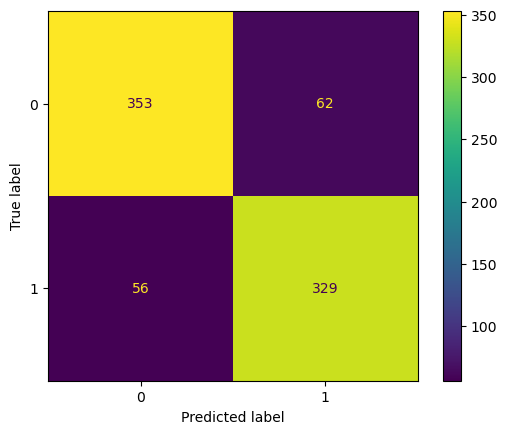

In [36]:
ConfusionMatrixDisplay.from_estimator(svm, X_test_normalized, y_test)

La SVM est le modèle le plus adapté à notre problème. Le score est similaire au RandomForest, mais elle crée beaucoup moins de faux-négatifs.